<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_04_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Training

In this tutorial, we will introduce different topics related to the training phase of deep neural networks,  including data augmentation, optimization/regularization techniques, weight initializations, loss function and hyperparameters tuning.


## Preliminary

Similarly to past tutorials, we load the MNIST dataset and define a model for digit classification by using our own method `get_data_model`. We also define a new function `plot_history`, which plots the training loss and if required the validation loss. 

In [3]:
import numpy as np
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
def get_data_model(args = {}):
  # Returns simple model, flattened MNIST data and categorical labels
  num_classes=10
  
  # the data, shuffled and split between train and test sets
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

  x_train= x_train.astype('float32')
  x_test= x_test.astype('float32')

  x_train /= 255
  x_test /= 255

  y_train=to_categorical(y_train,num_classes)
  y_test=to_categorical(y_test,num_classes)

  # Load simple model
  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=(784,), **args))
  model.add(Dense(512, activation='relu', **args))
  model.add(Dense(10, activation='softmax', **args))
  return model, x_train, y_train, x_test, y_test

model, x_train, y_train, x_test, y_test = get_data_model()
model.summary()


Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


## Optimizers

Once the model has been created, it is necessary to define an optimizer. In a deep learning problem, optimizers take in each time-step the gradient of the loss function respect to the weights of the network. Then, the weights are updated to minimize the loss value. Different optimizers follow different rules for updating the weights. For example, the vanilla Stochastic Gradient Descent (SGD) only uses the gradient in the current time-step $t$ and the learning rate to update the weights. 

Since there are methods more prone to get stuck in local minima and other methods converging faster, the choice of the optimizer can potentially affect both the final performance and the speed of convergence.  A nice visualization of such behavior is the following animation, where you can notice some methods, i.e., Adadelta in yellow, and Rmsprop in black converge significantly faster than SGD in red failing in local minima. 

![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

The animation above is from [Sebastian Ruder's blog](http://ruder.io/optimizing-gradient-descent/), who wrote an interesting article about the math formulation and properties of different optimizers. In this tutorial, we will follow a hands-on approach and will mainly focus on how to use them in Keras. 


As a rule of thumb, Adam is usually easier to tune due to the adaptive learning rate, whereas SGD with momentum [has been shown](https://arxiv.org/pdf/1712.07628.pdf) to reach better results when tuned correctly. Consult the official documentation [Optimizers in Keras](https://keras.io/optimizers/) to see the available implemented optimizers in Keras.

When defining a model in Keras we need to call the `compile` method, which  requires two arguments in string format: a loss function and an optimizer. For example, in the next piece of code we use as optimizer Adam, which is an widely used optimizer, and as our loss function the categorical cross-entropy.

In [4]:
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.fit(x_train,y_train,batch_size=100, epochs=10, verbose=1,validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 205us/step - loss: 0.2059 - val_loss: 0.0958
Epoch 2/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.0776 - val_loss: 0.0890
Epoch 3/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.0490 - val_loss: 0.0672
Epoch 4/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.0366 - val_loss: 0.0677
Epoch 5/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.0299 - val_loss: 0.0709
Epoch 6/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.0223 - val_loss: 0.0853
Epoch 7/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0197 - val_loss: 0.0859
Epoch 8/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.0171 - val_loss: 0.0771
Epoch 9/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.0155 - val_loss: 0.0827
Epo

## Initializers


Neural Networks have a large number of weights that we need to initialize before starting training. Weight initialization is a crucial step in tuning neural networks as different initial values can lead the model to reach different local minima. The weights are usually randomly initialized by different algorithms, e.g. Xavier,  He_normal, LeCun. 

In Keras, you can set the particular initialization strategy you want to use as an argument when declaring a layer. For example, in the function `Dense()` which defines the mapping $y= Ax + b$, you can initialize the kernel values ($A$ in the equation) with a normal distribution (by default the `stddev` is 0.05) and the bias ($b$ in the equation) with $0$ using the code below.

In [0]:
linear_layer = Dense(64, kernel_initializer='random_normal',
                bias_initializer='zeros')

Now let's check the weights of the layers and see if they follow the distributions we set. 

In [6]:
from keras.layers import Input
import numpy as np
from keras import backend as K
input_x = K.variable(np.random.random((1, 64)))
y = linear_layer(input_x)
weights = linear_layer.get_weights()
# Weights return an array with [kernel, bias]
# Let's see the kernel weights
print(weights[0])

[[ 0.04035673  0.0194908   0.04579018 ... -0.05498166  0.07672695
   0.05728488]
 [ 0.03315612  0.00971843  0.06341536 ... -0.02826347  0.03701399
   0.03372418]
 [ 0.02284417 -0.02099259  0.0636925  ... -0.0410321   0.02925151
  -0.00930472]
 ...
 [ 0.01462967 -0.00760535  0.01634391 ... -0.00366985  0.01083108
  -0.03410503]
 [ 0.02426023  0.03741289 -0.03115737 ... -0.00929854 -0.04618856
  -0.03070786]
 [-0.08283774  0.03905994  0.05300927 ...  0.02122171 -0.05231838
   0.01647863]]


In [7]:
# Now let's check that the mean is 0 and stddev is 0.05
print(weights[0].mean(), weights[0].std())

-0.0008680033 0.050154995


In [8]:
# Let's print the bias now
print(weights[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The number of initializations available in Keras is listed [in the documentation](https://keras.io/initializers/). By default in Keras the kernel weights are initialized as `'glorot_uniform'` and the bias to `'zeros'`. Glorot uniform, which is also called Xavier initialization was defined [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). It samples the weights from a uniform distribution, whose range depends on the number of input and output units. Another initializer quite used is the `he_normal`, which draws the weights from a truncated normal distribution.

## Loss

Another important step in training deep neural networks is the choice of the loss function, which strictly depends on your problem. In this tutorial, we will introduce two typical losses i.e., cross entropy and mean squared error, for two standard problems in machine learning: classification and regression. The full list of standard losses in Keras is available [here](https://keras.io/losses/).

### Classification

For classification problems, the standard loss used is the cross-entropy loss. For the binary case, the formula is $\mathcal{L} = y\log(p) + (1-y)\log(1-p)$, where $p$ is a probability value between $[0, 1]$.
To constrain the activations to assume such values, typically a [Sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function) is applied. In Keras, the presented binary classification loss is called `binary_crossentropy`, and it accepts as target a vector with an element in the range $[0, 1]$ (usually either $0$ or $1$) per input element.

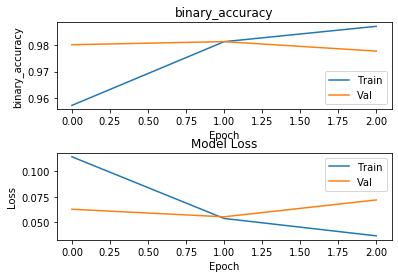

In [9]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.pop()
model.add(Dense(1, activation='sigmoid'))

# This three lines transform the problem in a binary one
# We want to know if the number is bigger than 5 (label 1) or smaller (label 0)
y_train = np.argmax(y_train, axis = 1)
y_train[y_train < 5] = 0
y_train[y_train >= 5] = 1


model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'binary_accuracy')

In case the number of classes is higher than 2, we use the cross-entropy loss, which has the form of $\mathcal{L} = -\sum_i y_i\log(p_i)$. The loss is called `categorical_crossentropy` in Keras, and accepts one-hot encoded vectors. A one-hot encoded vector has dimensionality $C$, where $C$ is the number of classes. All of the elements are set to 0, minus the corresponding class $c$, which is set to 1. If we have a vector of labels with a scalar from $[0, C)$ per training example, we can transform it into a one-hot encoding form by using the function `to_categorical`.  

Let's see an example using MNIST data.

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# The labels are an scalar from 0 to 9 per example
print(y_train[:5])

[5 0 4 1 9]


In [11]:
keras.utils.to_categorical(y_train[:5])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

The output vector needs to be $\sum_i p_i = 1$, and we achieve that by applying the softmax activation function to the output vector.

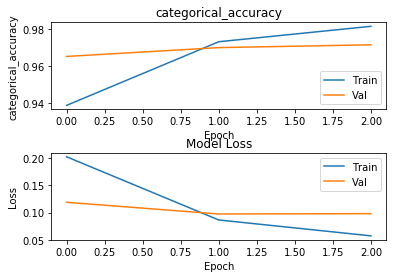

In [12]:
# We use the function get_data_model, which already applies to_categorical
_, x_train, y_train, x_test, y_test = get_data_model()

### Model defined with softmax
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'categorical_accuracy')

### Regression
For regression problems it is quite standard to use as losses the Mean Squared Error (MSE) or Mean Absolute Error (MAE), depending on the problem. 

As in the evaluation measures exercise, we will load the Boston Housing dataset.

In [13]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print(y_train[:10])

57344/57026 [==============================] - 0s 1us/step
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


We see that the labels are float numbers, and our goal is to predict them. To do so, we need a network that has only one output. Now, we will train the network using MAE and MSE. 

In [0]:
model_mae = Sequential()
model_mae.add(Dense(100, activation='relu', input_shape=(13,)))
model_mae.add(Dense(1))
model_mae.compile(optimizer='adam',loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mae.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

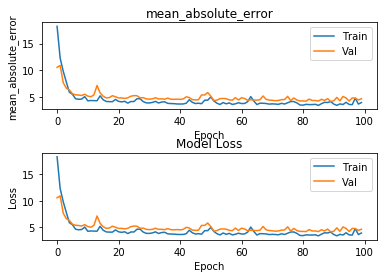

In [15]:
plot_history(history, 'mean_absolute_error')

In [0]:
model_mse = Sequential()
model_mse.add(Dense(100, activation='relu', input_shape=(13,)))
model_mse.add(Dense(1))
model_mse.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mse.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

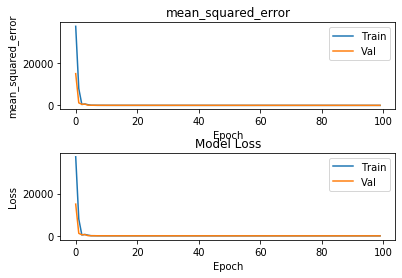

In [17]:
plot_history(history, 'mean_squared_error')

In [18]:
results = model_mae.evaluate(x_test, y_test)
print('MAE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

102/102 [==============================] - 0s 91us/step
MAE trained model achieves MAE: 4.4162 and MSE: 32.7921


In [19]:
results = model_mse.evaluate(x_test, y_test)
print('MSE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

102/102 [==============================] - 0s 71us/step
MSE trained model achieves MAE: 4.5942 and MSE: 42.6106


The plots show that training using MSE as loss achieves a better MSE and worse MAE in the test set compared to the model training with MAE loss.

Now let's print some predicted prices from the test set, along with the actual price, just to have an intuition of the output values.

In [20]:
pred_prices = model_mae.predict(x_test)
print(np.around(pred_prices[:10, 0], 2))
print(y_test[:10])

[13.58 23.49 26.32 28.32 26.89 25.07 29.7  25.96 22.47 21.81]
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


A problem usually treated as a regression problem with deep learning approaches is depth estimation, where the depth of an image is estimated using the RGB information. Some other regression losses are also used in some settings (e.g. Huber loss or Reverse Huber loss, or the already introduced Mean Percentage Absolute Error), but MAE and MSE are the most widely used. 

## Regularization
As mentioned in the lecture, regularization is an effective tool to fight some of the problems we may have during training, such as vanishing/exploding gradients or overfitting to the training set. We now mention some of the usual ways to regularize our training process. 

### Loss regularizers

[Regularizers](https://keras.io/regularizers/)  put some penalties to the optimization process. In practice by penalizing large values, weights are constrained to be small which can help us prevent overfitting.

In Keras regularization works on a per-layer basis. It means you can define a regularization function for each layer. In particular,  you can specify three regularization parameters each one related to a different type of penalty:

*   `kernel_regularizer`: a penalty depending on the value of the kernel weights, e.g, larger kernel weights result in larger penalization.
*   `bias_regularizer`: a penalty depending on the loss function is applied to the value of the bias. If you want the output function to pass through (or have an intercept closer to) the origin, you can use the `bias_regularizer`.
*   `activity_regularizer`: a penalty applied to the loss function depending on the layer's output. It results in smaller outputs in value when this regularizer is applied.

Standard regularizers that can be applied are $l_1$, $l_2$ and $l_1+l_2$. 
In the example below, we check the difference in training and validation accuracy by varying the used regularization strategy.


Training with regularization value of 0.001000
10000/10000 [==============================] - 1s 58us/step
Training with regularization value of 0.000300
10000/10000 [==============================] - 1s 54us/step
Training with regularization value of 0.000100
10000/10000 [==============================] - 1s 64us/step
Training with regularization value of 0.000030
10000/10000 [==============================] - 1s 60us/step
Training with regularization value of 0.000010
10000/10000 [==============================] - 1s 67us/step
Training with regularization value of 0.000003
10000/10000 [==============================] - 1s 68us/step
Training with regularization value of 0.000001
10000/10000 [==============================] - 1s 68us/step


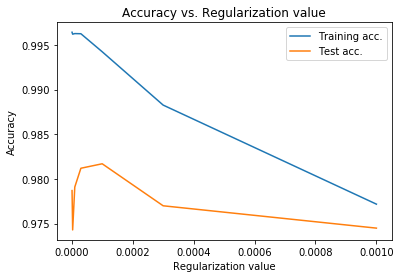

In [21]:
from keras import regularizers
test_accuracy = []
train_accuracy = []
reg_values = [0.001, 0.0003, 0.0001, 0.00003, 0.00001, 0.000003, 0.000001]

for reg_val in reg_values: 
  print('Training with regularization value of {:f}'.format(reg_val))
  args_dict = {'kernel_regularizer': regularizers.l2(reg_val)}
  model, x_train, y_train, x_test, y_test = get_data_model(args_dict)
  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x_train, y_train, epochs=10, batch_size=256, verbose=0)
  train_accuracy.append(history.history['acc'][-1])
  test_accuracy.append(model.evaluate(x_test, y_test)[-1])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(reg_values, train_accuracy)
plt.plot(reg_values, test_accuracy)
plt.legend(['Training acc.', 'Test acc.'])
plt.title('Accuracy vs. Regularization value')
plt.ylabel('Accuracy')
plt.xlabel('Regularization value')
plt.show()
  

In this example, regularizing the weights actually dropped the final accuracy, although we see how the gap between training and test accuracy decreases. 

### Dropout

Dropout is another regularization technique that can be applied. A Dropout layer deactivates during training some weights of the model by setting elements to 0 with a certain probability. The dropout value, i.e., the probability of disabling the input units, can be set as a parameter when defining a layer. In the evaluation phase, all of the weights are activated and dropout does not have any effect on the model. The dropout layer also scales during training the non-zero elements by 1/(1-prob_drop) to maintain a similar norm between training and evaluation. 

For example, in the following layer, the dropout value is 0.3, meaning 30% of the input data is switched off during training.

In [0]:
prob_drop = 0.3
drop = keras.layers.Dropout(prob_drop)

In [23]:
from keras.layers import Dropout
import numpy as np
from keras import backend as K
x = np.random.random((1, 512))
input_x = K.variable(x)
# Set learning phase is used to manually setting
# the phase (0 evaluation, 1 training)
# Dropout only affects training, so we set it to 1
K.set_learning_phase(1)
y = K.eval(drop(input_x))
print('Input (10 elements)')
print(x[0,0:10])
print('Output (10 elements)')
print(y[0,0:10])

Input (10 elements)
[0.31631946 0.02094538 0.18838843 0.84363962 0.74000742 0.95778424
 0.9440196  0.08268878 0.5437736  0.52854259]
Output (10 elements)
[0.45188496 0.02992198 0.         0.         1.0571535  1.3682632
 0.         0.11812683 0.7768194  0.75506085]


We now check what percentage of elements have been set to 0, and what is the scaling value the other elements have.

In [24]:
print('Drop percentage, should be close to {:f}'.format(prob_drop))
print(((y==0).sum())/(1.0*y.shape[1]))

print('Scaling value, should be {:f}'.format(1/(1-prob_drop)))
print(((y[y!=0]).sum())/(1.0*x[y!=0].sum()))


Drop percentage, should be close to 0.300000
0.294921875
Scaling value, should be 1.428571
1.428571394912989


### Batch Normalization

Batch Normalization computes the mean and the standard deviation per channel, i.e. given a feature map of dimensionality $B\times H\times W\times C$ ($B$ is batch size, $H,W$ spatial dimensions and $C$ number of feature channels) the layer computes the mean $\mu$ and standard deviation $\sigma$, where $\mu$ and $\sigma$ have dimensionality $1\times 1\times 1\times C$. Then, the mean $\mu$ and the standard deviation $\sigma$ of the batch are used to standardize all of the dimensions of the input feature to follow a distribution with mean 0 and variance 1.
The layer is defined in Keras by using:

In [0]:
batch_norm = keras.layers.BatchNormalization(axis=-1, input_shape=[10,10,1])

Now we will generate a batch of 512x1 (a batch of 512 vectors of only 1 channel) using `np.random.random`, which is a uniform distribution under the $[0, 1)$ interval, resulting in mean 0.5 and variance 1/12. Finally, the batch normalization layer scales the distribution to have mean 0 and variance 1.



In [26]:
from keras.layers import BatchNormalization
import numpy as np
from keras import backend as K
K.set_learning_phase(1)
x = np.random.random((512, 10, 10, 1))
input_x = K.variable(x)
y = K.eval(batch_norm(input_x))
print('Input')
print(x[:10, 0, 0, 0])
print('Output')
print(y[:10, 0, 0, 0])

Input
[0.82702676 0.07231708 0.48185461 0.05481748 0.09892957 0.41481065
 0.39484623 0.0929214  0.6994425  0.12298952]
Output
[ 1.1229484  -1.4812295  -0.06809197 -1.5416132  -1.3894014  -0.2994318
 -0.36832044 -1.4101329   0.6827101  -1.3063807 ]


In [27]:
# Input mean should be ~0.5 and var ~1/12=0.0833
print(x.mean(), x.var())
# Output mean should be ~0 and var ~1
print(y.mean(), y.var())

0.5015881786295021 0.08298823971008071
4.3921172e-08 0.98809344


Batch normalization changes behaviour in evaluation mode. During training the layer also tracks the moving average of both mean and variance, which are then used to normalize the testing data without having to use the statistics from the testing batch.

## HyperParameters Tuning

When training our model, we need to decide the value of several hyperparameters, what regularization techniques we employ, or the loss used to train the model, among others. To decide these values we should not use as guidance the performance in the test set, as it may lead to overfitting to that set, and in turn to an erroneous estimate of the performance of the model in non-seen data. Hence, we use what is called a validation set, which we use to tweak the hyperparameters. To define a validation split automatically in Keras, we can use two relevant arguments in the `fit` method: `validation_split` and `validation_data`. The argument passed to `validation_split` (0 by default) determines the ratio of the training set for validation purposes. For example,    
```
model.fit(x_train, y_train, ..., validation_split=0.2)
```
uses 20% of `x_train` as validation data.

Unfortunately, the validation data is randomly sampled and we can not fix the same splits during evaluations, so results are not directly comparable. To solve this problem, an option is using the `validation_data` argument, where we can pass directly the split of data we want to use as validation in the form of a tuple `(data, labels)`. 

Let's see how we can do the split. First, we load the data:

In [0]:
model, x_train, y_train, x_test, y_test = get_data_model()

Now, we want to split `x_train` in training and validation, but we also need to follow the same partition for `y_train`. We can do so by using `numpy` functions:

In [29]:
import numpy

# We initialize the pseudo-random number generator 
# in order to be able to reproduce the splits
numpy.random.seed(1234)

# We shuffle the indices in case the dataset follows an ordering
# If we do not shuffle we may take only a subset of classes if the dataset is
# ordered
indices = numpy.random.permutation(x_train.shape[0])

val_ratio = 0.2
n_indices_train = int((1-val_ratio) * x_train.shape[0])
train_idx, val_idx = indices[:n_indices_train], indices[n_indices_train:]
x_train, x_val = x_train[train_idx,:], x_train[val_idx,:]
y_train, y_val = y_train[train_idx], y_train[val_idx]
print(x_train.shape[0], x_val.shape[0])


48000 12000


Another way is to use a package called `sklearn`, which contains a function called `train_test_split` that performs the split.

In [30]:
# Let's reload the data first
model, x_train, y_train, x_test, y_test = get_data_model()

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20)
print(x_train.shape[0], x_val.shape[0])


48000 12000


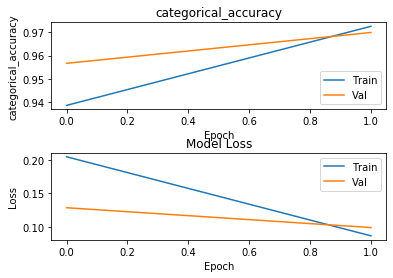

In [31]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=2, batch_size=32, verbose=0, validation_data=(x_val, y_val))
plot_history(history, 'categorical_accuracy')


We can compare the performance of several models by using the defined `x_val` and `y_val` variables. When we are happy with the performance in the validation split, we then evaluate the model in the unseen test data. Let's check if the accuracy in the test set is similar to the accuracy in the validation set in this case.

In [32]:
print('Accuracy in the validation set is {:.2f}'.format(model.evaluate(x_val, y_val)[-1]))
print('Accuracy in the test set is {:.2f}'.format(model.evaluate(x_test, y_test)[-1]))

12000/12000 [==============================] - 1s 46us/step
Accuracy in the validation set is 0.97
10000/10000 [==============================] - 0s 39us/step
Accuracy in the test set is 0.97


We know how to define a validation set and how to use it during the training process. An important step now is how to retrieve the model with the highest validation performance during training. We already mentioned this in the introductory Keras tutorial, but let's explain this again now that we know how to define a validation split. By default, Keras returns the last model after training $N$ epochs. We can instead choose to retrieve the model with the best validation performance by using the [`EarlyStopping`](https://keras.io/callbacks/#earlystopping) callback.

In [33]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stop])


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 7s 153us/step - loss: 0.0651 - categorical_accuracy: 0.9794 - val_loss: 0.0994 - val_categorical_accuracy: 0.9702
Epoch 2/20
48000/48000 [==============================] - 7s 137us/step - loss: 0.0467 - categorical_accuracy: 0.9852 - val_loss: 0.0777 - val_categorical_accuracy: 0.9762
Epoch 3/20
48000/48000 [==============================] - 7s 136us/step - loss: 0.0343 - categorical_accuracy: 0.9892 - val_loss: 0.0977 - val_categorical_accuracy: 0.9757
Epoch 4/20
48000/48000 [==============================] - 6s 134us/step - loss: 0.0314 - categorical_accuracy: 0.9900 - val_loss: 0.0842 - val_categorical_accuracy: 0.9796
Epoch 5/20
48000/48000 [==============================] - 7s 141us/step - loss: 0.0247 - categorical_accuracy: 0.9921 - val_loss: 0.0825 - val_categorical_accuracy: 0.9798
Epoch 6/20
48000/48000 [==============================] - 6s 135us/step - loss: 0.0209 - c

We check that the performance of the saved model is the same as the obtained in the best epoch in terms of validation accuracy.

In [34]:
model.evaluate(x_val, y_val)

12000/12000 [==============================] - 1s 43us/step


[0.11302502553185548, 0.9811666666666666]

One of the most important parameters to tweak is the training rate, which controls the update step performed during the backpropagation. Keras provides two callbacks that allow us to modify the learning rate during training. One is `LearningRateScheduler`, which allows us to define a rule to vary the learning rate depending on the epoch. For example, using the `lr_scheduler` function (found [here](https://stackoverflow.com/questions/39779710/setting-up-a-learningratescheduler-in-keras)), we can modify the loss function so that every 3 epochs is multiplied by 0.1.

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 8s 158us/step - loss: 0.1999 - categorical_accuracy: 0.9384 - val_loss: 0.1090 - val_categorical_accuracy: 0.9659
Epoch 2/10
48000/48000 [==============================] - 6s 132us/step - loss: 0.0836 - categorical_accuracy: 0.9736 - val_loss: 0.1033 - val_categorical_accuracy: 0.9690
Epoch 3/10
48000/48000 [==============================] - 6s 133us/step - loss: 0.0573 - categorical_accuracy: 0.9814 - val_loss: 0.1096 - val_categorical_accuracy: 0.9691
Epoch 4/10
48000/48000 [==============================] - 6s 133us/step - loss: 0.0194 - categorical_accuracy: 0.9943 - val_loss: 0.0697 - val_categorical_accuracy: 0.9806
Epoch 5/10
48000/48000 [==============================] - 6s 131us/step - loss: 0.0104 - categorical_accuracy: 0.9970 - val_loss: 0.0653 - val_categorical_accuracy: 0.9820
Epoch 6/10
48000/48000 [==============================] - 6s 134us/step - loss: 0.0067 - c

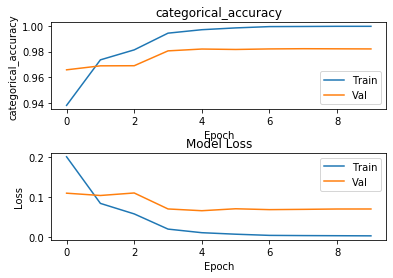

In [35]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 3
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
    
lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
initial_lr = K.get_value(model.optimizer.lr)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[lrate])
print('Initial Learning Rate: {:.4f}'.format(initial_lr))
print('Final Learning Rate: {:.10f}'.format(K.eval(model.optimizer.lr)))
plot_history(history, 'categorical_accuracy')

Let's plot the progress of the learning rate in each epoch to check how the learning rate is decreased every three epochs as we defined in `lr_scheduler`.

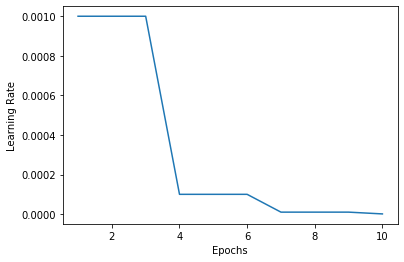

In [36]:
learning_rate = history.history['lr']
plt.plot(range(1, len(learning_rate)+1), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

Another callback provided is `ReduceLROnPlateau`, which reduces the learning rate whenever a given metric has stopped improving. There are 5 important arguments:

 * `monitor`: we specify the metric we want to track
 * `patience`: number of epochs without improvement before reducing lr
 * `factor`: the new learning rate will be `new_lr = lr * factor`
 * `min_lr`: sets the minimum lr
 * `min_delta`: margin to define when the metric has stopped improving
 

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 7s 153us/step - loss: 0.1982 - categorical_accuracy: 0.9398 - val_loss: 0.1212 - val_categorical_accuracy: 0.9629
Epoch 2/10
48000/48000 [==============================] - 7s 137us/step - loss: 0.0870 - categorical_accuracy: 0.9727 - val_loss: 0.1007 - val_categorical_accuracy: 0.9685
Epoch 3/10
48000/48000 [==============================] - 7s 140us/step - loss: 0.0555 - categorical_accuracy: 0.9825 - val_loss: 0.0868 - val_categorical_accuracy: 0.9744
Epoch 4/10
48000/48000 [==============================] - 7s 141us/step - loss: 0.0464 - categorical_accuracy: 0.9856 - val_loss: 0.0916 - val_categorical_accuracy: 0.9741
Epoch 5/10
48000/48000 [==============================] - 6s 134us/step - loss: 0.0123 - categorical_accuracy: 0.9962 - val_loss: 0.0710 - val_categorical_accuracy: 0.9822
Epoch 6/10
48000/48000 [==============================] - 6s 132us/step - loss: 0.0048 - c

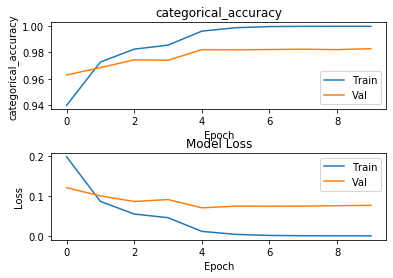

In [37]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.00001, min_delta = 0.01)
model, x_train, y_train, x_test, y_test = get_data_model() 
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
initial_lr = K.get_value(model.optimizer.lr)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])
print('Initial Learning Rate: {:.4f}'.format(initial_lr))
print('Final Learning Rate: {:.10f}'.format(K.eval(model.optimizer.lr)))
plot_history(history, 'categorical_accuracy')

Again, we check how the learning rate has changed. You can check that the learning has indeed decreased when the `val_loss` has not improved by more than 0.01 until it reached the `min_lr` value.

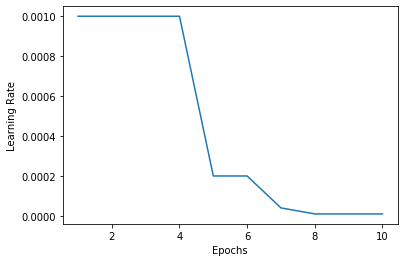

In [38]:
learning_rate = history.history['lr']
plt.plot(range(1, len(learning_rate)+1), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

### Searching for the right set of parameters

Apart from the learning rate, there are several hyperparameters we can tune: the optimizer parameters (momentum, beta, rho, decay), the dropout rate, the number of neurons/feature maps, batch size, regularization weights, etc...  After some time working with the models, you gain an intuition of what set of parameters work better. However, performing a proper search of hyperparameters may improve the results. A way to do this (among several others) is performing a search of parameters. Several available packages can help you with hyperparameter optimization in Keras, the one we will use is called [`talos`](https://github.com/autonomio/talos).

In [39]:
!pip install talos==0.4.9

     |████████████████████████████████| 839kB 9.4MB/s 
  Created wheel for talos: filename=talos-0.4.9-cp36-none-any.whl size=37106 sha256=26a3c930a8970b110d07a6e50055fe319d43cf198a8c9373a4ed32aab0097d03
  Stored in directory: /root/.cache/pip/wheels/eb/6b/c0/5b58a4767728bb467656ccd70b4fc2e286840c1e8ffa2631ac
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=e0fd5979154f0a02908b5624ef54bfaab61364e8e40dd715e34dad971e5832d4
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad
  Created wheel for chances: filename=chances-0.1.9-cp36-none-any.whl size=41609 sha256=2704ae1a7a8bc4e14e449749228e4149348e253819b5f427d554fe18c82eb58c
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315afb67eb14c6
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp36-none-any.whl size=3601 sha256=dd0c0373c60548b3bc76a2c51b229bafcd445e11c3aa9bd1d03b2295116ca649
  Store

Now we show a quick example of how to do it. We set only 2 epoch of training and `grid_downsampling=0.05`, which controls the number of sets of hyperparameters tested.

In [40]:
import talos as ta
_, x_train, y_train, x_test, y_test = get_data_model()

def model_scan(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  model.add(Dense(params['first_neuron'], input_shape=(784,), activation=params['activation']))
  model.add(Dropout(params['dropout']))
  model.add(Dense(10, activation=params['last_activation']))

  model.compile(optimizer=params['optimizer'](lr = params['lr']),
                loss=params['losses'],
                metrics=['categorical_accuracy'])
  
  out = model.fit(x_train, y_train,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  verbose=0,
                  validation_data=[x_val, y_val])
  
  return out, model
p = {}
p['lr'] = [0.0001, 0.001]
p['first_neuron'] = [8, 16, 32, 64, 128]
p['batch_size'] =  [20, 40]
p['epochs'] =  [2]
p['dropout'] =  [0, 0.40, 0.7]
p['weight_regularizer'] = [None]
p['optimizer'] =  [keras.optimizers.Adam, keras.optimizers.SGD]
p['losses'] =  ['categorical_crossentropy']
p['activation'] = ['relu', 'tanh']
p['last_activation'] =  ['softmax']
## grid_downsample limits the number of combinations run in the search
## to the fraction set (e.g. 0.05 runs 5% of the possible combinations) 
h = ta.Scan(x_train, y_train,
          params=p,
          model=model_scan,
          grid_downsample=0.05,
          print_params=True,
          disable_progress_bar=True)

{'lr': 0.001, 'first_neuron': 64, 'batch_size': 40, 'epochs': 2, 'dropout': 0, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax'}
{'lr': 0.0001, 'first_neuron': 8, 'batch_size': 20, 'epochs': 2, 'dropout': 0, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': 'categorical_crossentropy', 'activation': 'tanh', 'last_activation': 'softmax'}
{'lr': 0.001, 'first_neuron': 8, 'batch_size': 40, 'epochs': 2, 'dropout': 0.4, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax'}
{'lr': 0.0001, 'first_neuron': 128, 'batch_size': 40, 'epochs': 2, 'dropout': 0.7, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax'}
{'lr': 0.001, 'first_neuro

Now we check the results of the experiment.

In [41]:
from talos import Reporting
r = Reporting(h)
# returns the results dataframe
r.data

,round_epochs,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,first_neuron,batch_size,epochs,dropout,weight_regularizer,optimizer,losses,activation,last_activation
0,2,1.236038,0.747333,1.471593,0.683000,0.0010,64,40,2,0.0,None,<class 'keras.optimizers.SGD'>,categorical_crossentropy,relu,softmax
1,2,2.081936,0.292222,2.135361,0.249857,0.0001,8,20,2,0.0,None,<class 'keras.optimizers.SGD'>,categorical_crossentropy,tanh,softmax
2,2,0.598860,0.868667,1.131837,0.593405,0.0010,8,40,2,0.4,None,<class 'keras.optimizers.Adam'>,categorical_crossentropy,relu,softmax
3,2,2.213844,0.190000,2.386598,0.118048,0.0001,128,40,2,0.7,None,<class 'keras.optimizers.SGD'>,categorical_crossentropy,relu,softmax
4,2,0.244798,0.931278,0.245371,0.929119,0.0010,16,20,2,0.0,None,<class 'keras.optimizers.Adam'>,categorical_crossentropy,relu,softmax
5,2,0.753048,0.852389,1.163909,0.618690,0.0001,16,40,2,0.4,None,<class 'keras.optimizers.Adam'>,categorical_crossentropy,relu,softmax
6,2,1.484827,0.726167,1.838920,0.351095,0.0010,32,20,2,0.7,None,<class 'keras.optimizers.SGD'>,categorical_crossentropy,relu,softmax
7,2,0.649194,0.865889,1.085386,0.641429,0.0001,16,20,2,0.4,None,<class 'keras.optimizers.Adam'>,categorical_crossentropy,relu,softmax
8,2,0.603161,0.873278,0.873031,0.780524,0.0001,16,20,2,0.4,None,<class 'keras.optimizers.Adam'>,categorical_crossentropy,tanh,softmax
9,2,0.757226,0.829889,0.978696,0.780048,0.0001,8,40,2,0.0,None,<class 'keras.optimizers.Adam'>,categorical_crossentropy,relu,softmax


[Talos' documentation](https://autonomio.github.io/docs_talos/#introduction) provides more information about the package.

## Data augmentation
Deep learning models are data-hungry, tend to overfit with small training sets and its performance benefit from large training sets. A way to synthetically create more data is using data augmentation. Now, we will show some examples of data augmentation for images.
### Images
Data augmentation techniques such as rotation, color jittering, scale or cropping are usually applied in deep learning pipelines for vision applications. The idea is to take as input an image, apply a transformation to it, and then use it for training.

Keras includes a preprocessing module, with all [these transformations](https://keras.io/preprocessing/image/) implemented. The preprocessing module can be imported by doing




In [0]:
from keras.preprocessing.image import ImageDataGenerator

Then we need to fit it to the input data using `fit` (which computes statistics from the dataset, such as means and std values) and use `flow` to apply the transformations to the input data. In the function `plot_data_augmentation` defined in the code cell below we can see the process of fitting the data and then using flow to iterate over the generator.



In [0]:
def plot_data_augmentation(augmentation_gen = ImageDataGenerator()):
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  augmentation_gen.fit(np.expand_dims(x_train, -1))
  for X_batch, y_batch in augmentation_gen.flow(np.expand_dims(x_train, -1), y_train, batch_size=5, shuffle=False):
    for i in range(0, 5):
      plt.subplot(150 + 1 + i)
      plt.imshow(X_batch[i, :].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

We will now visualize some of the transformations available to use.

First, we plot some images without any transformations applied for comparison.

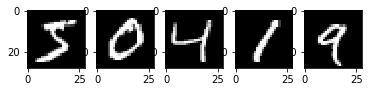

In [44]:
plot_data_augmentation()

### Rotation
A standard transformation is to rotate the image. We can do so by initializing ImageDataGenerator with `rotation_range=rot_val`.

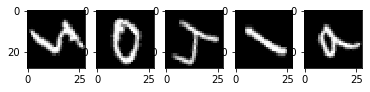

In [45]:
# We first define the transformation we want to apply
augmentation_gen = ImageDataGenerator(rotation_range=90)
plot_data_augmentation(augmentation_gen)

### Shift

We can define a maximum range of both horizontal (`width_shift_range`) and vertical (`height_shift_range`) shift.

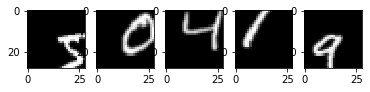

In [46]:
augmentation_gen = ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3)
plot_data_augmentation(augmentation_gen)

### Zooming
Zooming into the image can be done with `zoom_range`.

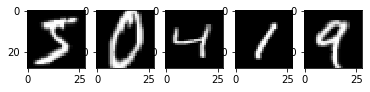

In [47]:
augmentation_gen = ImageDataGenerator(zoom_range=0.4)
plot_data_augmentation(augmentation_gen)

### Flip

We can define either horizontal flip (`horizontal_flip`) or vertical (`vertical_flip`).  

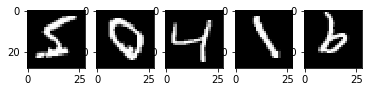

In [48]:
augmentation_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
plot_data_augmentation(augmentation_gen)

### Combining transformations
We can combine all the transformations and train a model. The `ImageDataGenerator` is a generator, so we need to use the method `fit_generator`, which is explained [in the documentation](https://keras.io/models/sequential/).

In [49]:
augmentation_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
augmentation_gen.fit(np.expand_dims(x_train, -1))
train_gen = augmentation_gen.flow(np.expand_dims(x_train, -1), keras.utils.to_categorical(y_train))
model = Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28, 1)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit_generator(train_gen, samples_per_epoch=len(x_train), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 1.0975 - categorical_accuracy: 0.6282
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.6859 - categorical_accuracy: 0.7733
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5789 - categorical_accuracy: 0.8091
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5231 - categorical_accuracy: 0.8298
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4851 - categorical_accuracy: 0.8431
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4608 - categorical_accuracy: 0.8516
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4374 - categorical_accuracy: 0.8581
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4300 - categorical_accuracy: 0.8613
Epoch 9/10
1875/1875 [==============================] - 22s 11ms/step - 

In these examples we showed practical examples of data augmentation for images. However, other modalities, such as text or audio can also benefit from data augmentation as shown in the lecture slides.

## Tensorboard
Tensorboard is quite useful to monitor the different metrics in real time. Both Tensorflow and Pytorch users (using the TensorboardX module) can use it. Tensorboard can be used in Keras by using the Tensorboard callback available ([documentation here](https://keras.io/callbacks/)).

However, to make it working in a Colab environment, we need to follow a different process, which is explained [here](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6). When you run the following piece of code, a Tensorboard link will be displayed. If you click on it, and you will be redirected to the Tensorboard site.

In [50]:
!pip install tensorboardcolab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-02-04 19:20:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.224.175.112, 34.237.203.145, 34.235.200.97, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.224.175.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  38.0MB/s    in 0.3s    

2020-02-04 19:20:47 (38.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [51]:
import tensorboardcolab as tbc
K.clear_session()
tboard = tbc.TensorBoardColab()
from tensorboardcolab import TensorBoardColabCallback

Wait for 8 seconds...
TensorBoard link:
https://90a41320.ngrok.io


Now, we can use a callback function to show the training progress in the given link. 

In [52]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.fit(x_train, y_train, epochs=10, batch_size=32,  validation_split=0.2, callbacks=[TensorBoardColabCallback(tboard)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 130us/step - loss: 0.2022 - val_loss: 0.1401
Epoch 2/10
48000/48000 [==============================] - 6s 129us/step - loss: 0.0847 - val_loss: 0.0967
Epoch 3/10
48000/48000 [==============================] - 6s 129us/step - loss: 0.0599 - val_loss: 0.0910
Epoch 4/10
48000/48000 [==============================] - 6s 126us/step - loss: 0.0465 - val_loss: 0.0919
Epoch 5/10
48000/48000 [==============================] - 6s 124us/step - loss: 0.0352 - val_loss: 0.1096
Epoch 6/10
48000/48000 [==============================] - 6s 125us/step - loss: 0.0283 - val_loss: 0.1106
Epoch 7/10
48000/48000 [==============================] - 6s 126us/step - loss: 0.0266 - val_loss: 0.1021
Epoch 8/10
48000/48000 [==============================] - 6s 127us/step - loss: 0.0243 - val_loss: 0.1246
Epoch 9/10
48000/48000 [==============================] - 6s 129us/step - loss: 0.0234 - val_loss: 0.0

In the Tensorboard website you should see two sections: *Scalars* and *Graph*. In *Scalars* there is the plot with the training and validation loss per epoch, and in *Graph* you should have the graph of your model. You can also plot images, histograms, distributions and other things in Tensorboard, which makes it quite useful to keep track of the training progress. You will not have to use Tensorboard for the tutorials, however it is a nice visualization tool that can be useful for future projects.

# Coursework

### Task 1: Tuning a classification model
In a machine learning problem, and especially when using a deep learning approach, finding the right set of hyperparameters can make the difference between a model that performs poorly and a model with great accuracy. 

For this exercise, you will be training a CNN to reach a good accuracy in CIFAR-100. You can start by using the CNN you defined in the `CNN_Introduction` tutorial, however you can use any architecture you wish.

**Report:**
*   Perform a hyperparameter search and find a set of hyperparameters capable of obtaining at least 50% of accuracy on the test set. As done in `CNN_Introduction`, present a bar figure with the test and training accuracies for different design choices. Discuss which parameters have a significant impact on the network performance.
*   For the best architecture and hyperparameters you found, report in a table the accuracies obtained in the training and the test set depending of the optimizer chosen. Carry out similar comparison for different  initialization methods. 
*   Apply data augmentation to the input images and analyze the differences in training and test accuracy per epoch vs. training without data augmentation. Carry out similar comparison for dropout and batch normalization.
 